# Test Technique  (bonus 2)

**Author:** [Yannis Tannier](https://github.com/yannistannier)<br>
**Date created:** 2021/10/16<br>
**Last modified:** 2021/10/19<br>

## Extraction d'embedding et comparaison

In [53]:
import pandas as pd
import tensorflow_addons as tfa
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import faiss
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt
import cv2

#### 1) On récupère la liste des erreurs  ainsi que le jeu d'entrainement et de test :

In [45]:
list_errors = np.array([   0,   32,   33,   49,  177,  195,  277,  333,  412,  492,  561,
        608,  611,  614,  630,  709,  730,  753,  795,  825,  826,  887,
        902,  914,  982, 1015, 1045, 1173])

In [77]:
train_val = pd.read_csv("train_val.csv")
test = pd.read_csv("test.csv")

#### 2) On charge le modèle :

In [28]:
model = keras.models.load_model('model_best.h5')

#### 3) On modifie maintenant l'output pour ne pas prendre la sortie de la dernière couche du réseau mais la sortie de l'avant-dernière couche, celle juste après le GlobalAveragePooling

In [30]:
outputs = model.get_layer("batch_normalization_3").output
embedding = keras.Model(model.input, outputs, name="EfficientNet_embedding")

#### 4) On extrait un embedding pour chaque image du jeu d'entrainement et de test :

In [9]:
datagen_test = ImageDataGenerator()
test_generator = datagen_test.flow_from_dataframe(dataframe=test, 
        x_col="name",
        shuffle=False,
        target_size=(120,120), 
        batch_size=1,
        class_mode=None,
        rescale=1.0/255,
        seed=2020 )

Found 1500 validated image filenames.


In [36]:
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_dataframe(dataframe=train_val, 
        x_col="name",
        shuffle=False,
        target_size=(120,120), 
        batch_size=1,
        class_mode=None,
        rescale=1.0/255,
        seed=2020 )

Found 8500 validated image filenames.


In [37]:
features_queries = embedding.predict(test_generator)
features_pools = embedding.predict(train_generator)

#### 4) On normalise : 

In [41]:
features_queries_norm = normalize(features_queries)
features_pools_norm = normalize(features_pools)

#### 5) Maintenant pour chaque image du jeu de test, on va récupérer les 50 images du jeu d'entrainement :

In [106]:
index = faiss.IndexFlatIP(features_pools.shape[1])
index.add(features_pools_norm)

D, I = index.search(features_queries_norm, 50)

#### 6) On affiche le résultat de la recherche par similarité pour toutes les images ou le réseau s'est trompé dans la prédiction

In [51]:
images_queries = test["name"]
images_pools = train_val["name"]

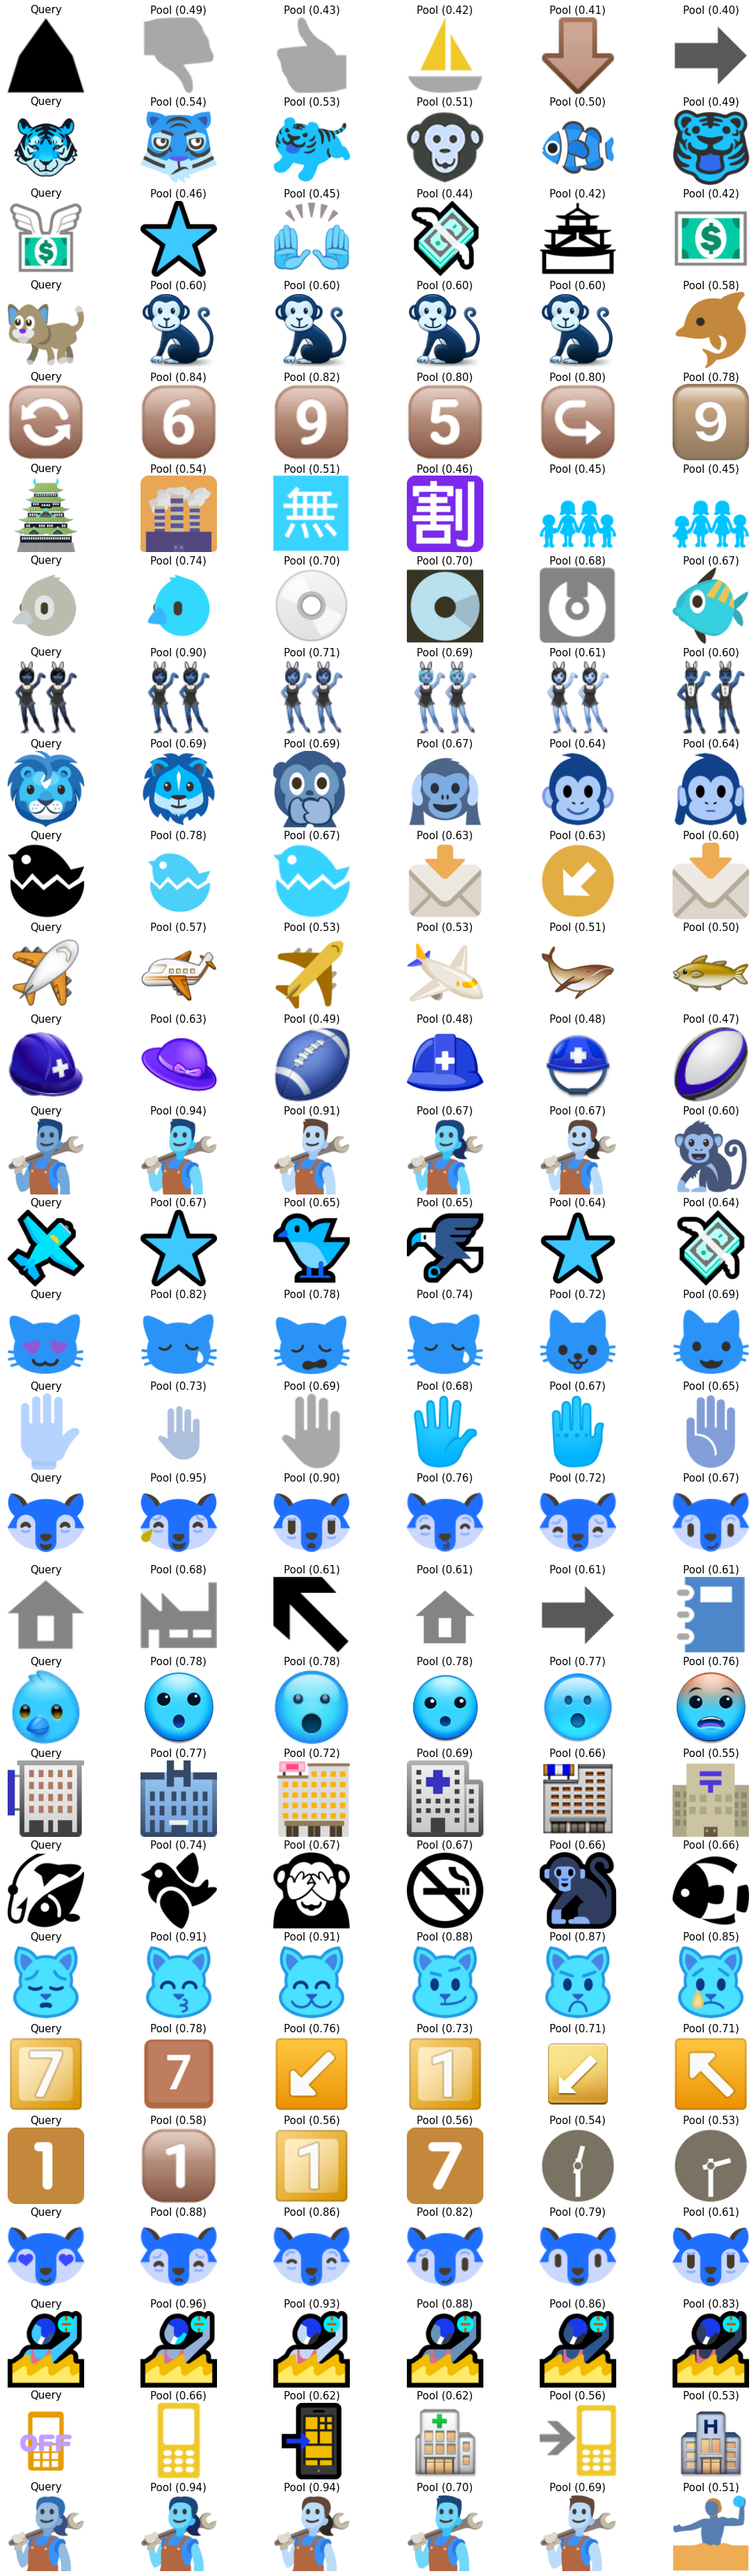

In [102]:
plt.figure(figsize=(20,70))
idx = 0
for e in list_errors:
    
    ie = I[e]
    de = D[e]
    
    e_image = images_queries[e]
    
    idx += 1
    plt.subplot(29,6,idx)
    plt.title("Query", fontsize=15)
    plt.imshow(cv2.imread(e_image))
    plt.axis("off")
    
    for i,d in zip(ie[:5], de[:5]):
        idx += 1
        ee_image = images_pools[i]
        plt.subplot(29,6,idx)
        plt.title("Pool ({:.2f})".format(d), fontsize=15)
        plt.imshow(cv2.imread(ee_image))
        plt.axis("off")

plt.show()